# Data Preparation

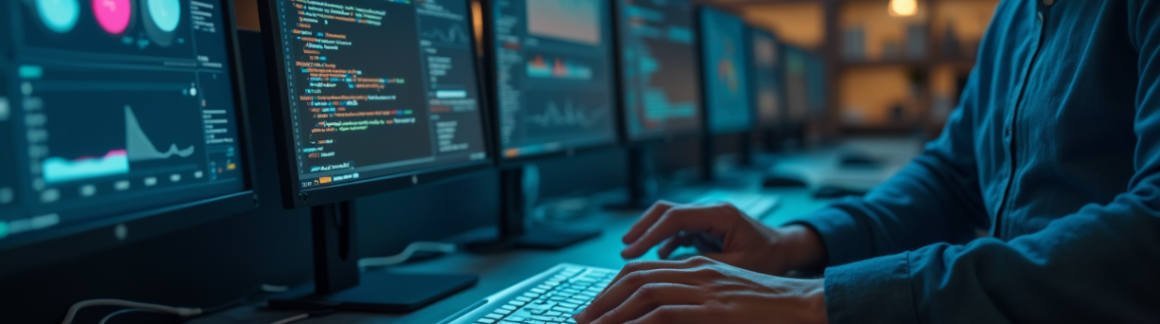

In this competition we are tasked with large amounts of noisy data. We first need to reduce the complexity and use domain knowledge to clean the data and to help modeling it. By doing so, we need to keep track of time, as our submission can only take 9h and involves the preprocessing of ~800 planets! 

The pipeline below mostly follows the steps outlined by the hosts here: https://www.kaggle.com/code/gordonyip/update-calibrating-and-binning-astronomical-data/notebook.

In [ ]:
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import multiprocessing as mp
from numpy.polynomial import Polynomial
from astropy.stats import sigma_clip
import numba


ROOT = "/kaggle/input/ariel-data-challenge-2024/"
VERSION = "v2"

sensor_sizes_dict = {
    "AIRS-CH0": [[11250, 32, 356], [32, 356]],
    "FGS1": [[135000, 32, 32], [32, 32]],
}  # input, mask

In [ ]:
planet_id = 14485303
sensor = "FGS1"

MODE = "train"

In [ ]:
def get_gain_offset(planet_id, sensor, mode):
    """
    Get the gain and offset for a given planet and sensor
    """
    gain_offset_csv = pd.read_csv(f"{ROOT}/{mode}_adc_info.csv")
    planet_gain_offset = gain_offset_csv[gain_offset_csv["planet_id"] == planet_id]

    gain = planet_gain_offset[sensor + "_adc_gain"].values
    offset = planet_gain_offset[sensor + "_adc_offset"].values
    return gain, offset

In [ ]:
%%timeit

get_gain_offset(planet_id, sensor, MODE)

In [ ]:
def read_data(planet_id, sensor, mode="train"):
    """
    Read the data for a given planet and sensor
    """
    # get all noise correction frames and signal
    signal = pd.read_parquet(
        ROOT + "/train/" + str(planet_id) + "/" + sensor + "_signal.parquet",
        engine="pyarrow",
    )
    dark_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/dark.parquet",
        engine="pyarrow",
    )
    dead_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/dead.parquet",
        engine="pyarrow",
    )
    linear_corr_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/linear_corr.parquet",
        engine="pyarrow",
    )
    flat_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/flat.parquet",
        engine="pyarrow",
    )
    # read_frame = pd.read_parquet(
    #     f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/read.parquet",
    #     engine="pyarrow",
    # )

    # reshape to sensor shape and cast to float64
    signal = signal.values.astype(np.float64).reshape(sensor_sizes_dict[sensor][0])
    dark_frame = dark_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )
    dead_frame = dead_frame.values.reshape(sensor_sizes_dict[sensor][1])
    flat_frame = flat_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )
    # read_frame = read_frame.values.reshape(sensor_sizes_dict[sensor][1])
    linear_corr = linear_corr_frame.values.astype(np.float64).reshape(
        [6] + sensor_sizes_dict[sensor][1]
    )

    return (
        signal,
        dark_frame,
        dead_frame,
        linear_corr,
        flat_frame,
        # read_frame,
    )

In [ ]:
%%timeit

read_data(planet_id, sensor, mode=MODE)

### AIRS data is larger and takes longer.

Note: it will already take about 800 * (1.46s + 0.47s) = ~26 minutes to just load the data into RAM for further processing! (single core estimate here and below)

In [ ]:
def ADC_convert(signal, gain, offset):
    """
    Step 1: Analog-to-Digital Conversion (ADC) correction

    The Analog-to-Digital Conversion (adc) is performed by the detector to convert the
    pixel voltage into an integer number. We revert this operation by using the gain
    and offset for the calibration files 'train_adc_info.csv'.
    """

    signal /= gain
    signal += offset
    return signal

In [ ]:
signal, dark_frame, dead_frame, linear_corr, flat_frame = read_data(
    planet_id, sensor, mode=MODE
)
gain, offset = get_gain_offset(planet_id, sensor, mode=MODE)

In [ ]:
np.isnan(signal).sum()

In [ ]:
%%timeit

ADC_convert(signal, gain, offset)

In [ ]:
signal = ADC_convert(signal, gain, offset)

In [ ]:
np.isnan(signal).sum()

In [ ]:
def mask_hot_dead(signal, dead, dark):
    """
    Step 2: Mask hot/dead pixel

    The dead pixels map is a map of the pixels that do not respond to light and, thus,
    can't be accounted for any calculation. In all these frames the dead pixels are
    masked using python masked arrays. The bad pixels are thus masked but left
    uncorrected. Some methods can be used to correct bad-pixels but this task,
    if needed, is left to the participants.
    """

    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))

    # Set values to np.nan where dead or hot pixels are found
    signal[dead] = np.nan
    signal[hot] = np.nan
    return signal

In [ ]:
%%timeit

mask_hot_dead(signal, dead_frame, dark_frame)

In [ ]:
signal = mask_hot_dead(signal, dead_frame, dark_frame)

In [ ]:
np.isnan(signal).sum()

In [ ]:
def apply_linear_corr(c, signal):
    """
    Step 3: linearity Correction

    The non-linearity of the pixels' response can be explained as capacitive leakage
    on the readout electronics of each pixel during the integration time. The number
    of electrons in the well is proportional to the number of photons that hit the
    pixel, with a quantum efficiency coefficient. However, the response of the pixel
    is not linear with the number of electrons in the well. This effect can be
    described by a polynomial function of the number of electrons actually in the well.
    The data is provided with calibration files linear_corr.parquet that are the
    coefficients of the inverse polynomial function and can be used to correct this
    non-linearity effect.
    Using horner's method to evaluate the polynomial
    """
    assert c.shape[0] == 6  # Ensure the polynomial is of degree 5

    return (
        (((c[5] * signal + c[4]) * signal + c[3]) * signal + c[2]) * signal + c[1]
    ) * signal + c[0]

In [ ]:
import cupy as cp

def apply_linear_corr_gpu(linear_corr, clean_signal):
    """
    Step 3: linearity Correction on GPU

    The non-linearity of the pixels' response can be explained as capacitive leakage
    on the readout electronics of each pixel during the integration time. The number
    of electrons in the well is proportional to the number of photons that hit the
    pixel, with a quantum efficiency coefficient. However, the response of the pixel
    is not linear with the number of electrons in the well. This effect can be
    described by a polynomial function of the number of electrons actually in the well.
    The data is provided with calibration files linear_corr.parquet that are the
    coefficients of the inverse polynomial function and can be used to correct this
    non-linearity effect.
    """
    # Convert the input arrays to CuPy arrays
    linear_corr_gpu = cp.asarray(linear_corr)
    clean_signal_gpu = cp.asarray(clean_signal)

    corrected_signal_gpu = (
        (
            (
                (linear_corr_gpu[5] * clean_signal_gpu + linear_corr_gpu[4])
                * clean_signal_gpu
                + linear_corr_gpu[3]
            )
            * clean_signal_gpu
            + linear_corr_gpu[2]
        )
        * clean_signal_gpu
        + linear_corr_gpu[1]
    ) * clean_signal_gpu + linear_corr_gpu[0]

    # Convert the result back to a NumPy array (if needed)
    corrected_signal = cp.asnumpy(corrected_signal_gpu)

    return corrected_signal

In [ ]:
np.nanmax(signal), np.nanmin(signal), np.nanmean(signal)

In [ ]:
%%timeit

apply_linear_corr(linear_corr, signal)

In [ ]:
%%timeit

apply_linear_corr_gpu(linear_corr, signal)

In [ ]:
assert np.allclose(apply_linear_corr(linear_corr, signal), apply_linear_corr_gpu(linear_corr, signal), equal_nan=True)

In [ ]:
signal = apply_linear_corr(linear_corr, signal)

In [ ]:
np.isnan(signal).sum()

In [ ]:
def clean_dark(signal, dark, dt):
    """
    Step 4: dark current subtraction

    The data provided include calibration for dark current estimation, which can be
    used to pre-process the observations. Dark current represents a constant signal
    that accumulates in each pixel during the integration time, independent of the
    incoming light. To obtain the corrected image, the following conventional approach
    is applied: The data provided include calibration files such as dark frames or
    dead pixels' maps. They can be used to pre-process the observations. The dark frame
    is a map of the detector response to a very short exposure time, to correct for the
    dark current of the detector.

    image - (dark * dt)

    The corrected image is conventionally obtained via the following: where the dark
    current map is first corrected for the dead pixel.
    """

    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal

In [ ]:
axis_info = pd.read_parquet(ROOT + "axis_info.parquet")
dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values

dt_fgs = np.ones(len(signal)) * 0.1

In [ ]:
if sensor == "AIRS-CH0":
    dt = dt_airs
    dt[1::2] += 4.5
elif sensor == "FGS1":
    dt = dt_fgs
    dt[1::2] += 0.1

In [ ]:
%%timeit

clean_dark(signal, dark_frame, dt)

In [ ]:
signal = clean_dark(signal, dark_frame, dt)

In [ ]:
np.isnan(signal).sum()

In [ ]:
def get_cds(signal):
    """
    Step 5: Get Correlated Double Sampling (CDS)

    The science frames are alternating between the start of the exposure and the end of
    the exposure. The lecture scheme is a ramp with a double sampling, called
    Correlated Double Sampling (CDS), the detector is read twice, once at the start
    of the exposure and once at the end of the exposure. The final CDS is the
    difference (End of exposure) - (Start of exposure).
    """

    return np.subtract(signal[1::2, :, :], signal[::2, :, :])

In [ ]:
%%timeit

get_cds(signal)

In [ ]:
signal = get_cds(signal)

In [ ]:
np.isnan(signal).sum()

In [ ]:
def correct_flat_field(flat, signal):
    """
    Step 6: Flat Field Correction

    The flat field is a map of the detector response to uniform illumination, to
    correct for the pixel-to-pixel variations of the detector, for example the
    different quantum efficiencies of each pixel.
    """

    return signal / flat

In [ ]:
%%timeit

correct_flat_field(flat_frame, signal)

In [ ]:
signal = correct_flat_field(flat_frame, signal)

In [ ]:
np.isnan(signal).sum()

In [ ]:
%%timeit

mean_signal = np.nanmean(signal, axis=(1, 2))

In [ ]:
mean_signal = np.nanmean(signal, axis=(1, 2))

In [ ]:
mean_signal

### Total

| Task | Time for AIRS [s] | Time for FGS [s] | Time for AIRS [s] UPDATE | Time for FGS [s] UPDATE |
| --- | --- | --- | --- | --- |
| Loading Data | 1.28 | 0.45 | 1.27 | 0.67 |
| ADC Conversion | 0.34 | 0.36 | 0.20 | 0.22 |
| Masking Hot/Dead Pixels | 3.13 | 3.35 | 0.125 | 0.134 |
| Linear Correction | 19.4 | 25.8 | 3.49 (1.96 GPU) | 5.61 (1.98 GPU) |
| Dark Cleaning | 1.44 | 1.68 | 0.898 | 0.957 |
| Correlated Double Sampling (CDS) | 0.21 | 0.28 | 0.189 | 0.246 |
| Transposing | 0.00 (negligible) | 0.00 | 0.00 | 0.00 |
| Flat Field Correction | 1.39 | 1.47 | 1.38 | 1.5 |
| Feature Engineering | 0.27 | 0.28 | 0.31 | 0.34 |

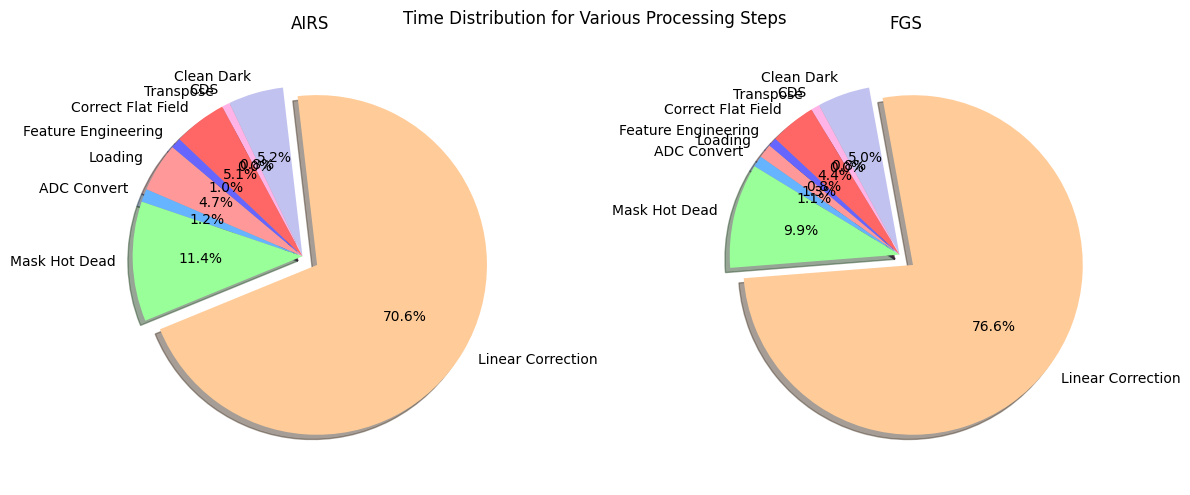
UPDATE:
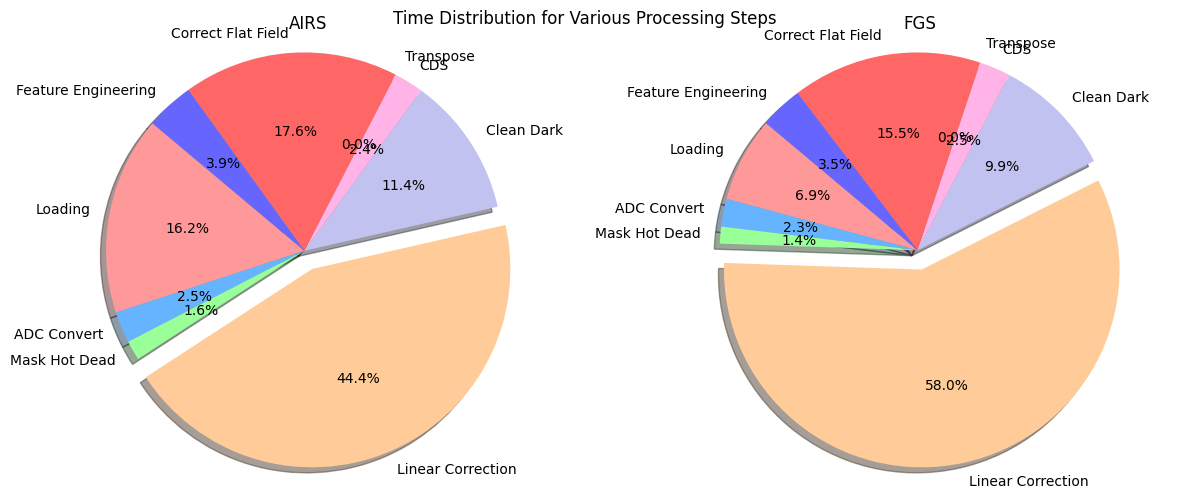

~~Total: 27.46s or a bit over 6h just to process the AIRS data on single core. Without Linear correction, we can bring it down to ~1h:50min. Impact on scores need to be checked! FGS takes even longer: 33.67s or ~7.5h~~

With the latest update, we can process all planets including Linear Correction!

In [ ]:
import os


os.environ["PREPROCESS_MODE"] = "train"

In [ ]:
%%writefile preprocess.py

import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import multiprocessing as mp
from astropy.stats import sigma_clip
import os
from numpy.polynomial import Polynomial


ROOT = "/kaggle/input/ariel-data-challenge-2024/"
VERSION = "v4"

MODE = os.getenv('PREPROCESS_MODE')


sensor_sizes_dict = {
    "AIRS-CH0": [[11250, 32, 356], [32, 356]],
    "FGS1": [[135000, 32, 32], [32, 32]],
}  # input, mask


def get_gain_offset(planet_id, sensor, mode):
    """
    Get the gain and offset for a given planet and sensor
    """
    gain_offset_csv = pd.read_csv(f"{ROOT}/{mode}_adc_info.csv")
    planet_gain_offset = gain_offset_csv[gain_offset_csv["planet_id"] == planet_id]

    gain = planet_gain_offset[sensor + "_adc_gain"].values
    offset = planet_gain_offset[sensor + "_adc_offset"].values
    return gain, offset


def read_data(planet_id, sensor, mode):
    """
    Read the data for a given planet and sensor
    """
    # get all noise correction frames and signal
    signal = pd.read_parquet(
        ROOT + "/train/" + str(planet_id) + "/" + sensor + "_signal.parquet",
        engine="pyarrow",
    )
    dark_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/dark.parquet",
        engine="pyarrow",
    )
    dead_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/dead.parquet",
        engine="pyarrow",
    )
    linear_corr_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/linear_corr.parquet",
        engine="pyarrow",
    )
    flat_frame = pd.read_parquet(
        f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/flat.parquet",
        engine="pyarrow",
    )
    # read_frame = pd.read_parquet(
    #     f"{ROOT}/{mode}/{planet_id}/{sensor}_calibration/read.parquet",
    #     engine="pyarrow",
    # )

    # reshape to sensor shape and cast to float64
    signal = signal.values.astype(np.float64).reshape(sensor_sizes_dict[sensor][0])
    dark_frame = dark_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )
    dead_frame = dead_frame.values.reshape(sensor_sizes_dict[sensor][1])
    flat_frame = flat_frame.values.astype(np.float64).reshape(
        sensor_sizes_dict[sensor][1]
    )
    # read_frame = read_frame.values.reshape(sensor_sizes_dict[sensor][1])
    linear_corr = linear_corr_frame.values.astype(np.float64).reshape(
        [6] + sensor_sizes_dict[sensor][1]
    )

    return (
        signal,
        dark_frame,
        dead_frame,
        linear_corr,
        flat_frame,
        # read_frame,
    )


def ADC_convert(signal, gain, offset):
    """
    Step 1: Analog-to-Digital Conversion (ADC) correction

    The Analog-to-Digital Conversion (adc) is performed by the detector to convert the
    pixel voltage into an integer number. We revert this operation by using the gain
    and offset for the calibration files 'train_adc_info.csv'.
    """

    signal /= gain
    signal += offset
    return signal


def mask_hot_dead(signal, dead, dark):
    """
    Step 2: Mask hot/dead pixel

    The dead pixels map is a map of the pixels that do not respond to light and, thus,
    can't be accounted for any calculation. In all these frames the dead pixels are
    masked using python masked arrays. The bad pixels are thus masked but left
    uncorrected. Some methods can be used to correct bad-pixels but this task,
    if needed, is left to the participants.
    """

    hot = sigma_clip(dark, sigma=5, maxiters=5).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))

    # Set values to np.nan where dead or hot pixels are found
    signal[dead] = np.nan
    signal[hot] = np.nan
    return signal


def apply_linear_corr(c, signal):
    """
    Step 3: linearity Correction

    The non-linearity of the pixels' response can be explained as capacitive leakage
    on the readout electronics of each pixel during the integration time. The number
    of electrons in the well is proportional to the number of photons that hit the
    pixel, with a quantum efficiency coefficient. However, the response of the pixel
    is not linear with the number of electrons in the well. This effect can be
    described by a polynomial function of the number of electrons actually in the well.
    The data is provided with calibration files linear_corr.parquet that are the
    coefficients of the inverse polynomial function and can be used to correct this
    non-linearity effect.
    Using horner's method to evaluate the polynomial
    """
    assert c.shape[0] == 6  # Ensure the polynomial is of degree 5

    return (
        (((c[5] * signal + c[4]) * signal + c[3]) * signal + c[2]) * signal + c[1]
    ) * signal + c[0]


def clean_dark(signal, dark, dt):
    """
    Step 4: dark current subtraction

    The data provided include calibration for dark current estimation, which can be
    used to pre-process the observations. Dark current represents a constant signal
    that accumulates in each pixel during the integration time, independent of the
    incoming light. To obtain the corrected image, the following conventional approach
    is applied: The data provided include calibration files such as dark frames or
    dead pixels' maps. They can be used to pre-process the observations. The dark frame
    is a map of the detector response to a very short exposure time, to correct for the
    dark current of the detector.

    image - (dark * dt)

    The corrected image is conventionally obtained via the following: where the dark
    current map is first corrected for the dead pixel.
    """

    dark = np.tile(dark, (signal.shape[0], 1, 1))
    signal -= dark * dt[:, np.newaxis, np.newaxis]
    return signal


def get_cds(signal):
    """
    Step 5: Get Correlated Double Sampling (CDS)

    The science frames are alternating between the start of the exposure and the end of
    the exposure. The lecture scheme is a ramp with a double sampling, called
    Correlated Double Sampling (CDS), the detector is read twice, once at the start
    of the exposure and once at the end of the exposure. The final CDS is the
    difference (End of exposure) - (Start of exposure).
    """

    return np.subtract(signal[1::2, :, :], signal[::2, :, :])


def correct_flat_field(flat, signal):
    """
    Step 6: Flat Field Correction

    The flat field is a map of the detector response to uniform illumination, to
    correct for the pixel-to-pixel variations of the detector, for example the
    different quantum efficiencies of each pixel.
    """

    return signal / flat


def process_planet(planet_id):
    """
    Process a single planet's data
    """
    axis_info = pd.read_parquet(ROOT + "axis_info.parquet")
    dt_airs = axis_info["AIRS-CH0-integration_time"].dropna().values

    for sensor in ["FGS1", "AIRS-CH0"]:
        # load all data for this planet and sensor
        signal, dark_frame, dead_frame, linear_corr, flat_frame = read_data(
            planet_id, sensor, mode=MODE
        )
        gain, offset = get_gain_offset(planet_id, sensor, mode=MODE)

        # Step 1: ADC correction
        signal = ADC_convert(signal, gain, offset)

        # Step 2: Mask hot/dead pixel
        signal = mask_hot_dead(signal, dead_frame, dark_frame)

        # Step 3: linearity Correction
        signal = apply_linear_corr(linear_corr, signal)

        # Step 4: dark current subtraction
        if sensor == "FGS1":
            dt = np.ones(len(signal)) * 0.1
            dt[1::2] += 4.5
        elif sensor == "AIRS-CH0":
            dt = dt_airs
            dt[1::2] += 0.1

        signal = clean_dark(signal, dark_frame, dt)

        # Step 5: Get Correlated Double Sampling (CDS)
        signal = get_cds(signal)

        # Step 6: Flat Field Correction
        signal = correct_flat_field(flat_frame, signal)

        # Feature engineering (just mean over all pixels, but masked via NaNs)
        mean_signal = np.nanmean(signal, axis=(1, 2))

        # save the processed signal
        np.save(
            str(planet_id) + "_" + sensor + f"_signal_{VERSION}.npy",
            mean_signal.astype(np.float64),
        )


if __name__ == "__main__":
    adc_info = pd.read_csv(ROOT + f"/{MODE}_adc_info.csv", index_col="planet_id")
    planet_ids = adc_info.index.tolist()

    # Use up to 4 threads!
    with mp.Pool(processes=4) as pool:
        list(tqdm(pool.imap(process_planet, planet_ids), total=len(planet_ids)))

    # join processed signals in a single file
    f_raw = np.full((len(planet_ids), 67500), np.nan, dtype=np.float64)
    a_raw = np.full((len(planet_ids), 5625), np.nan, dtype=np.float64)

    for i, planet_id in tqdm(enumerate(planet_ids)):
        f_raw[i] = np.load(
            str(planet_id) + f"_FGS1_signal_{VERSION}.npy"
        )
        a_raw[i] = np.load(
            str(planet_id) + f"_AIRS-CH0_signal_{VERSION}.npy"
        )

    np.save(f"fgs_{VERSION}.npy", f_raw, allow_pickle=False)
    np.save(f"airs_{VERSION}.npy", a_raw, allow_pickle=False)

    print("Processing complete!")

In [ ]:
!python preprocess.py

### Clean up intermediate data

Read more about it here and how to prevent the "Submission CSV Not Found" Error: https://www.kaggle.com/competitions/ariel-data-challenge-2024/discussion/528657

In [ ]:
!rm -rf *FGS1_signal*

In [ ]:
!rm -rf *AIRS-CH0_signal*